In [2]:
import pandas as pd

log_file=pd.read_csv('query_performance_log.csv')

### Missing data adjustment

In [3]:
log_file.start_time=log_file.start_time.shift(-1)
log_file.end_time=log_file.end_time.shift(-1)
log_file.time_lapse=log_file.time_lapse.shift(-1)

In [4]:
#pd.set_option('display.max_rows', 1500)
pd.set_option('display.max_rows', 50)

In [5]:
log_file_consensus=log_file[log_file['function_name'].str.match('consensus')]
log_file_consensus=log_file_consensus.drop([360, 361,382,384])
log_file_consensus.iloc[377, log_file_consensus.columns.get_loc('iteration')] = 0

In [6]:
#aggiornamento dati mancanti con la media degli intevalli adiacenti
from datetime import datetime, timedelta

t1=datetime.strptime(log_file_consensus.loc[376,'time_lapse'], '%H:%M:%S.%f')
t2=datetime.strptime(log_file_consensus.loc[381,'time_lapse'], '%H:%M:%S.%f')
t=(t2-t1)/2

log_file_consensus.loc[377,'time_lapse']=(t1+t).strftime("%H:%M:%S.%f")

In [7]:
log_file_coverage=log_file[log_file['function_name'].str.match('coverage')]
log_file_coverage=log_file_coverage.drop([380, 759,761])
log_file_coverage.iloc[376, log_file_coverage.columns.get_loc('iteration')] = 0

In [8]:
#aggiornamento dati mancanti con la media degli intevalli adiacenti
from datetime import datetime, timedelta

t1=datetime.strptime(log_file_coverage.loc[757,'time_lapse'], '%H:%M:%S.%f')
t2=datetime.strptime(log_file_coverage.loc[760,'time_lapse'], '%H:%M:%S.%f')
t=(t2-t1)/2

log_file_coverage.loc[758,'time_lapse']=(t1+t).strftime("%H:%M:%S.%f")

In [9]:
log_file_mpileup=log_file[log_file['function_name'].str.match('mpileup')]
log_file_mpileup=log_file_mpileup.drop([1139, 1140,1142])
log_file_mpileup.iloc[377, log_file_mpileup.columns.get_loc('iteration')] = 0

### Graph datasets creation

In [45]:
#creazione dataframe per grafici
import datetime

def produce_df_graph(log_file_df):
    diff=[]

    for row_num in log_file_df.index:
        t=datetime.datetime.strptime(log_file_df.loc[row_num,'time_lapse'], '%H:%M:%S.%f')
        dt=datetime.timedelta(hours=t.hour, minutes=t.minute, seconds=t.second,microseconds=t.microsecond)
        diff.append(dt.total_seconds())

    log_file_df['time_diff']=diff

    df_graph=pd.DataFrame(columns=['bases_num','mean','mean_time','sd','sd_time','iter_count'])

    df_graph['mean']=log_file_df.groupby(['data_range'])['time_diff'].mean()
    df_graph['sd']=log_file_df.groupby(['data_range'])['time_diff'].std()
    df_graph['sd']=df_graph['sd'].fillna(0)
    df_graph['iter_count']=log_file_df.groupby(['data_range'])['time_diff'].count()

    df_graph=df_graph.reset_index()

    for row in df_graph.index:
        df_graph.loc[row,'mean_time']=str(datetime.timedelta(seconds=df_graph.loc[row,'mean']))
        df_graph.loc[row,'sd_time']=str(datetime.timedelta(seconds=df_graph.loc[row,'sd']))
        df_graph.loc[row,'bases_num']=int(df_graph.loc[row,'data_range'].rsplit("-")[-1])

    df_graph=df_graph.drop('data_range',axis=1)


    df_graph=df_graph.sort_values('bases_num', ascending=True)
    df_graph=df_graph.set_index('bases_num')

    return df_graph

In [46]:
consensus_graph=produce_df_graph(log_file_consensus)

/home/eric/.local/lib/python3.8/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [48]:
coverage_graph=produce_df_graph(log_file_coverage)

/home/eric/.local/lib/python3.8/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [49]:
mpileup_graph=produce_df_graph(log_file_mpileup)

/home/eric/.local/lib/python3.8/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


### Graphs

In [54]:
consensus_graph.head()

,mean,mean_time,sd,sd_time,iter_count
bases_num,,,,,
17815,1.318379,0:00:01.318379,0.052770,0:00:00.052770,30
35630,6.577614,0:00:06.577614,0.346172,0:00:00.346172,30
53445,12.943899,0:00:12.943899,0.914045,0:00:00.914045,30
71260,20.788214,0:00:20.788214,0.616324,0:00:00.616324,30
89075,34.697177,0:00:34.697177,5.107141,0:00:05.107141,30


In [36]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcParams['figure.figsize'] = [10,5]
#plt.rcParams['figure.dpi'] = 150

def plot_graph(x,y,polyplot=True,grade=3):
    
    fig, ax = plt.subplots()
    
    ax.scatter( x ,y, marker=".", label='Data points')
    
    if polyplot==True:
        z = np.polyfit(x, y, grade)
        fit_equation = np.poly1d(z)
    
        X_fit = np.linspace(min(x), max(x), 1000)
        Y_fit = fit_equation(X_fit)
    
        ax.plot(X_fit, Y_fit, color='r', alpha=0.3, label='Polynomial fit')
    
    
    #base = "{}k"
    base = "{}"
    xlabels=[base.format(int(year)) for year in np.arange(0, max(x)/1000, 30)]
    
    ax.xaxis.set_ticks(np.arange(0, max(x), 30000),labels=xlabels)
    ax.yaxis.set_ticks(np.arange(0, max(y)+100, 200))
    
    ax.set_xticklabels(xlabels, rotation=45)
    
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    
    ax.set_xlabel('bases range (x1000)',labelpad=20)
    ax.set_ylabel('seconds',labelpad=20)
    
    
    return plt.show()

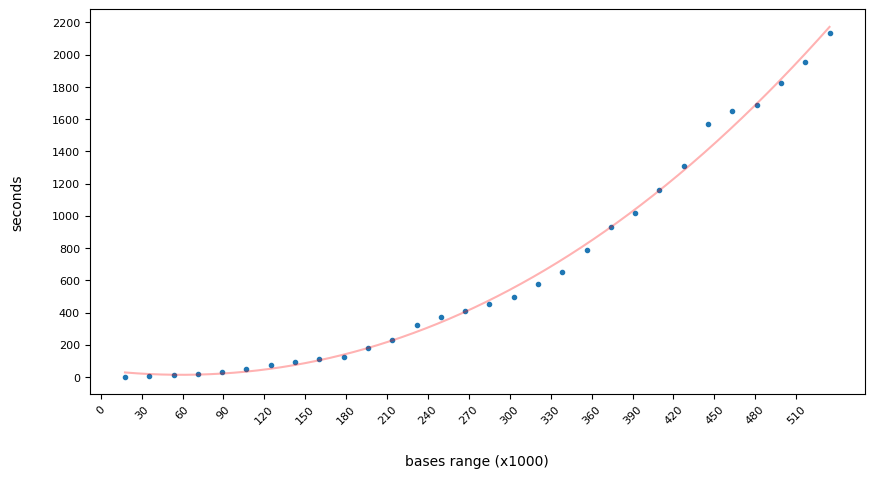

In [37]:
plot_graph(consensus_graph.index,consensus_graph['mean'],polyplot=True,grade=3)

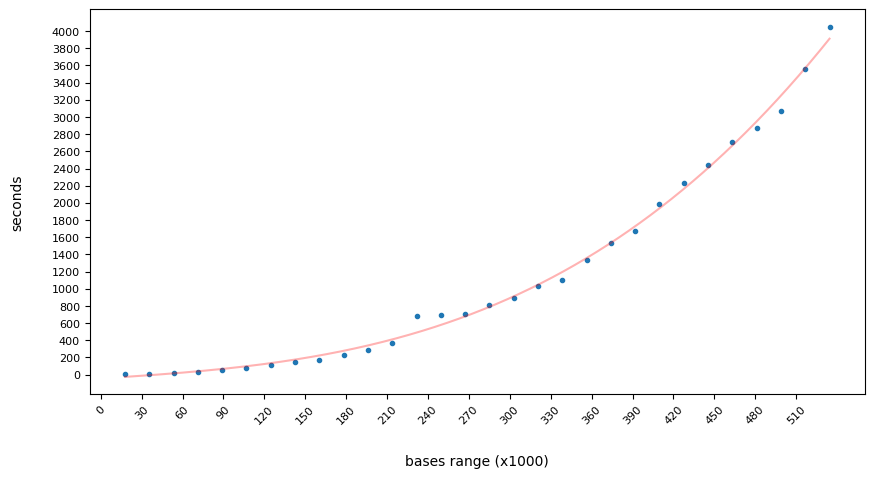

In [51]:
plot_graph(coverage_graph.index,coverage_graph['mean'],polyplot=True,grade=3)

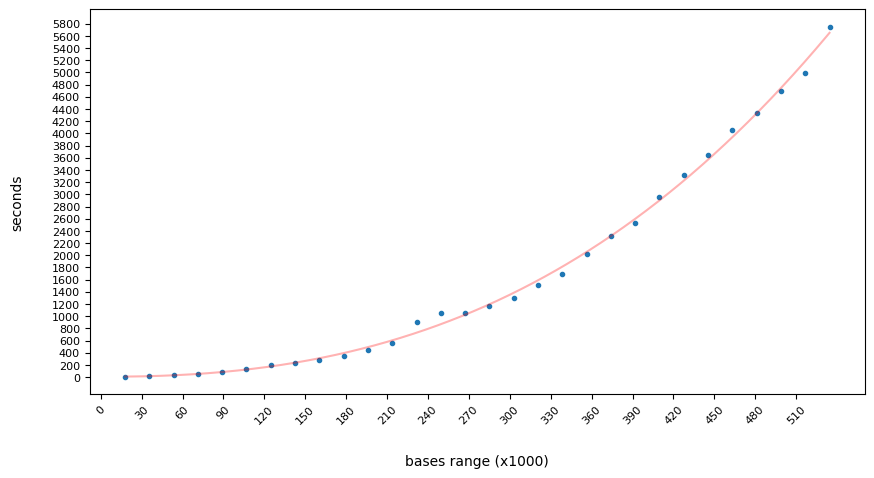

In [52]:
plot_graph(mpileup_graph.index,mpileup_graph['mean'],polyplot=True,grade=3)